# Proba project - Clustering based on information theory.
In this work, we implemented the clustering algorithm based on information theory, then tested it on 4 different datasets:

**Artificial datasets:**
- ds1
- ds2

**Real word datasets:**
- SP500
- MOVIES

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Clustering algorithm
We first implement the clutering algorithm according to the main idea of the article.

The 3 main functions of the algorithm are:
- **\_\_init\_\_** : get input value, initialize the $P(C|i)$ as a random (normalized) distribution and initialize all the parameters.
- **fit**: update $P(C|i)$ until converge.
- **update**: compute and update $P(C),P(i|C),S(C),S(C;i)$ according to $P(C|i)$.

We also implement 4 extensions:
- **predict**: return the label of cluster predicted for each item based on $P(C|i)$.
- **parameters**: compute $<S>$ and $I(C;i)$, return the parameters which are necessary for analysation.
- **sort**: sort the cluster finded by $S(C)$ and sort the items in each cluster by $S(C;i)$, which is used for visualization.
- **deterministic_rate**: Return the percentage of the items had a nearly deterministic assignment ($P (C|i) > 0.9$ for a particular $C$.)

In [59]:
class clustering:
    
    def __init__(self,simil,T,N_c,ε):
        
        self.simil = simil
        self.T = T
        self.N_c = N_c
        self.ε = ε
        
        '''initialize'''
        
        self.N = simil.shape[0]
        self.m = 0
        
        self.P_i = 1/self.N
        self.P_c = np.zeros(self.N_c)
        self.P_ci = np.zeros((self.N,self.N_c))
        self.P_ic = np.zeros((self.N_c,self.N))
        
        self.S_c = np.zeros(self.N_c)
        self.S_ci = np.zeros((self.N,self.N_c))

        '''set P(C|i) as a random (normalized) distribution'''
        
        for i in range(self.N): 
            r_list = np.array(list(np.random.random() for _ in range(self.N_c)))
            r_list = r_list/sum(r_list)
            self.P_ci[i] = r_list
        
        '''and update all the parameters with P(C|i)'''
        
        self.update_value()
        
        
    def fit(self):
        
        '''initialize a new matrix for P(m+1)(C|i)'''
        
        P_ci_new = np.zeros((self.N,self.N_c))
        
        stop = 0
        
        while stop == 0:
            
            '''compute P(m+1)(C|i) according to formula [7] in article'''
            
            for i in range(self.N):
                for c in range(self.N_c):
                    P_ci_new[i][c] = self.P_c[c]*np.exp((1/self.T) * (2*self.S_ci[i][c] - self.S_c[c]))
                P_ci_new[i] = P_ci_new[i]/sum(P_ci_new[i])
               
            self.m += 1
            stop = 1
            
            '''check if all the |P(m+1)(C|i) - P(m)(C|i)| <= ε'''
            
            for i in range(self.N):
                for c in range(self.N_c):
                    if abs(P_ci_new[i][c] - self.P_ci[i][c]) > self.ε:
                        stop = 0
                        continue
            
            '''update P(m)(C|i)'''
            
            for i in range(self.N):
                for c in range(self.N_c):
                    self.P_ci[i][c] = np.nan_to_num(P_ci_new[i][c]) #replace nan to  0 to avoid underflow

            '''and update all the parameters with new P(m)(C|i)'''
            
            self.update_value()
        
        print("Iteration times:",self.m)
    
    
    def predict(self):
        
        '''return the cluster with the highest probability P(C|i) as the cluster predicted'''
        
        predict_label = list(np.argmax(self.P_ci[i]) for i in range(self.N))
        
        return predict_label
    
    
    def parameters(self):
        
        '''compute <S> and return all the parameters necessary'''
        
        S = self.P_c.T @ self.S_c
        
        I = 0.
        for i in range(self.N):
            for c in range(self.N_c):
                I +=  np.nan_to_num(self.P_ci[i][c]*np.log(self.P_ci[i][c]/self.P_c[c]))
                
        I = I/self.N
        
        return S,I,self.S_c,self.S_ci,self.P_ci

        
    def update_value(self):
            
        '''compute P(C): P(c) = sum(P(C|i)*P(i))'''
        
        for c in range(self.N_c):
            self.P_c[c] = sum(self.P_ci[:,c]) * self.P_i
        
        '''compute P(i|C) according to Bayes' theorem'''
        
        for c in range(self.N_c):
            for j in range(self.N):
                self.P_ic[c][j] = self.P_ci[j][c] * self.P_i / self.P_c[c]
        
        '''compute S(C) according to formula [1] in article'''

        for c in range(self.N_c):
            for i in range(self.N):
                for j in range(self.N):
                    self.S_c[c] += self.P_ic[c][i] * self.P_ic[c][j] * self.simil[i][j]

        '''compute S(C;i) according to formula [6] in article'''

        for c in range(self.N_c):
            for i in range(self.N):
                for j in range(self.N):
                    self.S_ci[i][c] += self.P_ic[c][j] * self.simil[i][j]

                    
    def deterministic_rate(self):
        
        '''
        The percentage of the items had a nearly deterministic assignment
        [P (C|i) > 0.9 for a particular C]
        '''
        count = 0
        
        for elem in self.P_ci:
            for p in elem:
                if p >= 0.9:
                    count += 1
                    continue
                    
        percentage = round(count/self.N,3)
        
        return percentage

    def sort(self):

        '''sort the cluster according to the S(C)'''
        
        clusters_sorted = np.argsort(-self.S_c)
        cluster_dict = {}
        label = self.predict()
        
        '''build a library for the clusters sorted and their corresponding elements'''
        
        for c in clusters_sorted:
            for i,c_i in enumerate(label):
                if c_i == c:
                    cluster_dict.setdefault(c,[]).append(i)
        
        '''
        sort the elements according to the S(C;i)
        S(C;i): the similarity between i and the other elements in the same cluster
        '''
        
        element_list = []

        for c in cluster_dict.keys():
            S_ci_temp = []
            for i in cluster_dict[c]:
                S_ci_temp.append(self.S_ci[i][c])

            element_list.extend(list(np.array(cluster_dict[c])[np.argsort(-np.array(S_ci_temp))]))
        
        '''build an permutation matrix P and reorder the similarity matrix'''
        
        mat_P = np.zeros((self.N,self.N))

        for i,elem in enumerate(element_list):
            mat_P[elem][i] = 1
        
        mat_simil_sorted = mat_P.T @ self.simil @ mat_P
        
        '''return the similarity matrix reordered'''
        
        return mat_simil_sorted

## Artificial dataset:
### ds1
The data from this dataset is quite simple and labeled, we use this dataset to check whether our clustering algorithm can achieve reasonable results and find out the suitable $T$ and $\epsilon$.

In [60]:
def visualize(data,label,N_c):

    clusters = [[] for _ in range(N_c)]
    
    N = data.shape[0]
    for i in range(N):
        for c in range(N_c):
            if label[i] == c:
                clusters[c].append(data[i])
                
    plt.figure()
    colors = 'rgbycm'
    for c in range(N_c):
        clusters[c] = np.array(clusters[c])
        plt.scatter(clusters[c][:,0],clusters[c][:,1],c=colors[c])    

In [61]:
file = open("./dataset/scatter_ds1.d")

data = []
label = []

for line in file:
    line = line.strip().split(' ')
    data.append([float(line[0]),float(line[1])])
    label.append(int(line[2]))

data = np.array(data)
label = np.array(label)

In [62]:
file = open('./dataset/simil_ds1.d')

mat_simil = []

for line in file:
    line = line.strip().split(' ')
    mat_simil.append(list(float(line[i]) for i in range(len(line))))

mat_simil = np.array(mat_simil)

In [63]:
print(data.shape)
print(label.shape)
print(mat_simil.shape)

(300, 2)
(300,)
(300, 300)


In [64]:
cluster = clustering(mat_simil,0.1,3,0.01)
cluster.fit()

Iteration times: 5


In [65]:
predict_label = cluster.predict()
S,I,S_c,S_ci,P_ci = cluster.parameters()

In [66]:
print('S =',S)
print('S_c =',S_c)
print('I =',I)
print(cluster.deterministic_rate())

S = -8.350257101969982
S_c = [-8.62364036 -8.69842718 -7.73856156]
I = 1.0764919666488146
1.0


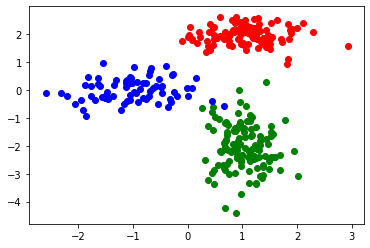

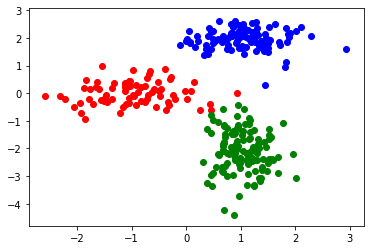

In [11]:
visualize(data,label,3)
visualize(data,predict_label,3)

In [12]:
mat_simil_sorted = cluster.sort()

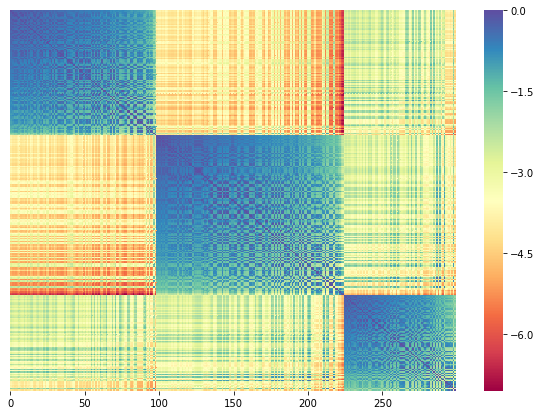

In [13]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted,xticklabels=50, yticklabels=False, cmap='Spectral')
plt.show()

### ds2
In this dataset, only the similarity matrix is given. We try to find out the number of clusters in this dataset by executing the algorithm and comparing the $S(C)$ obtained with different number of clusters $N_c$ and a fixed $T$.

In [14]:
file = open('./dataset/simil_ds2.d')

mat_simil1 = []

for line in file:
    line = line.strip().split(' ')
    mat_simil1.append(list(float(line[i]) for i in range(len(line))))

mat_simil1 = np.array(mat_simil1)

In [24]:
s_list = []
i_list = []
for c in range(2,10):
    cluster = clustering(mat_simil1,0.1,c,0.01)
    cluster.fit()
    S,I,_,_,_ = cluster.parameters()
    s_list.append(S)
    i_list.append(I)

Iteration times: 9
Iteration times: 27
Iteration times: 10
Iteration times: 31
Iteration times: 32
Iteration times: 34
Iteration times: 19
Iteration times: 15


In [25]:
'''Selon le resultat, 4 clusters sont présents'''
print(s_list) 
print(i_list)

[-27.893950977525048, -34.327675580892254, -17.495675921655376, -35.995143948967886, -35.02251562402545, -33.979783575078365, -22.74607364603481, -18.574651230080008]
[0.6842308133080398, 0.9723366690139289, 1.3528632301601113, 1.4714119403392003, 1.624107395707339, 1.8422251827262066, 1.931742568718489, 2.0795227327306227]


In [31]:
cluster = clustering(mat_simil1,0.1,4,0.01)
cluster.fit()
mat_simil_sorted = cluster.sort()
print(mat_simil_sorted.shape)

Iteration times: 7
(300, 300)


In [33]:
S,I,_,_,_ = cluster.parameters()
print(S) 
print(I)

-13.322846173086882
1.3528496774463854


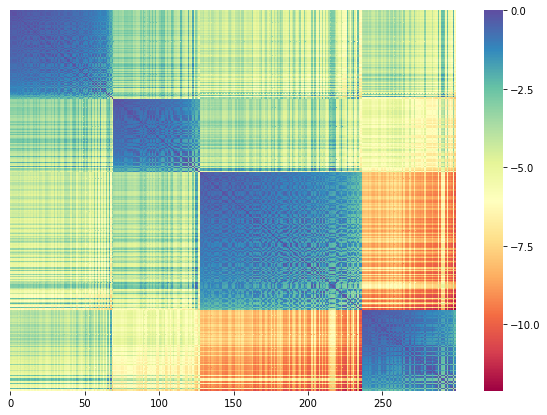

In [32]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted,xticklabels=50, yticklabels=False, cmap='Spectral')
plt.show()

## Real word dataset
### SP500

In [32]:
fileSP_simil = open('./dataset/SP500/mi_sp500.d')
fileSP_matType = open('./dataset/SP500/sp500_matType.d')

dataSP_simil = []
dataSP_matType = []

for line in fileSP_simil:
    line = line.strip().split(' ')
    dataSP_simil.append(list(float(line[i]) for i in range(len(line))))
    
for line in fileSP_matType:
    line = line.strip().split(' ')
    dataSP_matType.append(list(float(line[i]) for i in range(len(line))))
    
dataSP_simil = np.array(dataSP_simil)
dataSP_matType = np.array(dataSP_matType)

In [33]:
print(dataSP_simil.shape)
print(dataSP_matType.shape)

(501, 501)
(501, 208)


In [42]:
cluster_SP = clustering(dataSP_simil,0.05,10,0.01)
cluster_SP.fit()

In [44]:
predict_label_SP = cluster_SP.predict()
S_SP,S_c_SP,S_ci_SP,P_ci_SP = cluster_SP.parameters()

In [45]:
print('S_SP =',S_SP)
print('S_c_SP =',S_c_SP)

S_SP = 3.4441792162966274
S_c_SP = [4.66296008 4.81104856 2.63628689 3.52932123 1.88652265 3.22428221
 2.58248631 6.0528728  3.6763172  1.65938968]


1.0 501 501


In [48]:
mat_simil_sorted_SP = cluster_SP.sort()

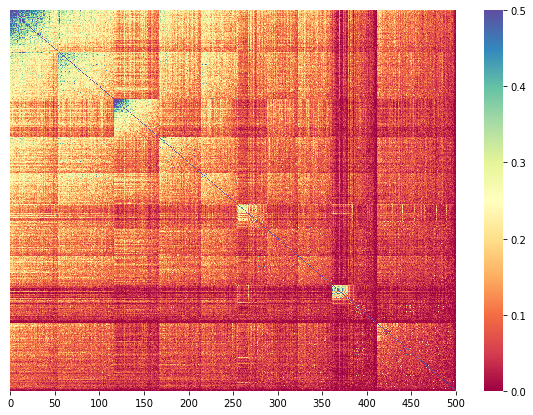

In [49]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted_SP,xticklabels=50, yticklabels=False,vmin=0, vmax=0.5, cmap='Spectral')
plt.show()

### MOVIES

In [50]:
fileMovie_simil = open('./dataset/MOVIES/mi_movie.d')
fileMovie_matType = open('./dataset/MOVIES/movie_labels.d')

dataMovie_simil = []
dataMovie_matType = []

for line in fileMovie_simil:
    line = line.strip().split(' ')
    dataMovie_simil.append(list(float(line[i]) for i in range(len(line))))
    
for line in fileMovie_matType:
    line = line.strip().split(' ')
    dataMovie_matType.append(list(float(line[i]) for i in range(len(line))))
    
dataMovie_simil = np.array(dataMovie_simil)
dataMovie_matType = np.array(dataMovie_matType)

In [51]:
print(dataMovie_simil.shape)
print(dataMovie_matType.shape)

(500, 500)
(500, 10)


In [52]:
print(dataMovie_matType[0])

[1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [53]:
cluster_Movie = clustering(dataMovie_simil,0.05,10,0.01)
cluster_Movie.fit()

Iteration times: 22


In [54]:
predict_label_Movie = cluster_Movie.predict()
S_Movie,S_c_Movie,S_ci_Movie,P_ci_Movie = cluster_Movie.parameters()

In [55]:
print('S_SP =',S_Movie)
print('S_c_SP =',S_c_Movie)

S_SP = 3.547029551571212
S_c_SP = [5.70003908 3.79801368 2.48157469 3.17137776 2.37441864 4.40559613
 3.04528648 1.79773159 4.55127286 5.96857553]


In [56]:
mat_simil_sorted_Movie = cluster_Movie.sort()

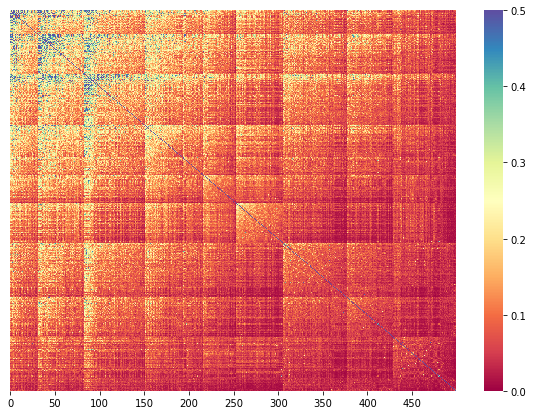

In [57]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted_Movie,xticklabels=50, yticklabels=False,vmin=0, vmax=0.5, cmap='Spectral')
plt.show()